<a href="https://colab.research.google.com/github/Rey-Morales-G/Alura_Telecom_X_2/blob/main/Alura_TelecomX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Data Preparation
We start by dropping irrelevant features and preparing the dataset for the algorithms.

We include the JSON flattening here so the columns like 'Contract' and 'InternetService' become usable numbers instead of text dictionaries.

Data Loading & Flattening

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Load data
url = "https://raw.githubusercontent.com/Rey-Morales-G/Alura_Telecom_X/main/TelecomX_Data.json"
df_raw = pd.read_json(url)

# 2. Flatten the nested columns (This fixes the 'df' is not defined error)
# We expand the dictionaries into individual columns
df_customer = pd.json_normalize(df_raw['customer'])
df_phone = pd.json_normalize(df_raw['phone'])
df_internet = pd.json_normalize(df_raw['internet'])
df_account = pd.json_normalize(df_raw['account'])

# 3. Create the 'df' variable correctly
df = pd.concat([df_raw[['customerID', 'Churn']], df_customer, df_phone, df_internet, df_account], axis=1)
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


Data Cleaning and Balancing
Following the course instructions: removing IDs, encoding, and using SMOTE to fix the imbalance.

In [4]:
# 1. Remove ID
df_clean = df.drop(columns=['customerID'], errors='ignore')

# 2. Convert text to numbers
# This creates columns like 'Churn_Yes'
df_final = pd.get_dummies(df_clean, drop_first=True)

# 3. Handle Balance (Using 'Churn_Yes' which is created by get_dummies)
X = df_final.drop('Churn_Yes', axis=1)
y = df_final['Churn_Yes']

smt = SMOTE(random_state=42)
X_res, y_res = smt.fit_resample(X, y)

print("Data is now balanced!")

Data is now balanced!


Correlation and Feature Selection
Visualizing relationships helps justify why we choose certain variables for the model.

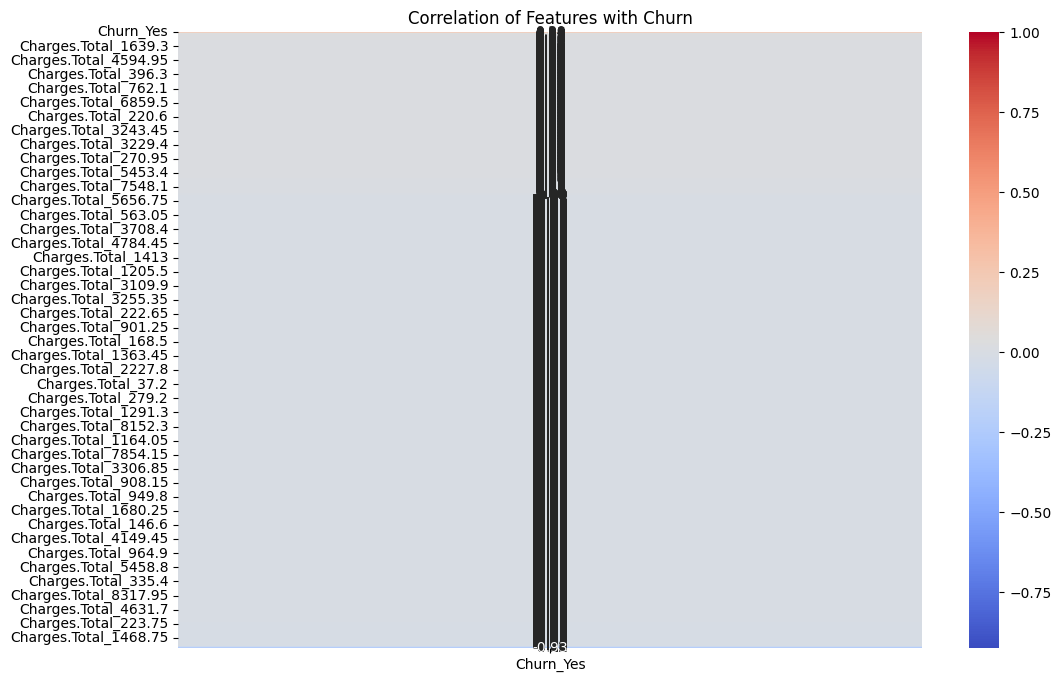

In [9]:
# 1. Heatmap to see correlations
plt.figure(figsize=(12, 8))
# We only correlate numeric columns
correlation_matrix = df_final.corr()
sns.heatmap(correlation_matrix[['Churn_Yes']].sort_values(by='Churn_Yes', ascending=False),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Features with Churn")
plt.show()

Predictive Models
I will compare KNN (Distance-based) and Random Forest (Tree-based).

We use an 80/20 split. KNN gets scaled data, while Random Forest uses the original data.

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# --- KNN ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Models trained successfully!")

Models trained successfully!


Evaluation and Variable Importance
This generates the metrics and charts for your final report.

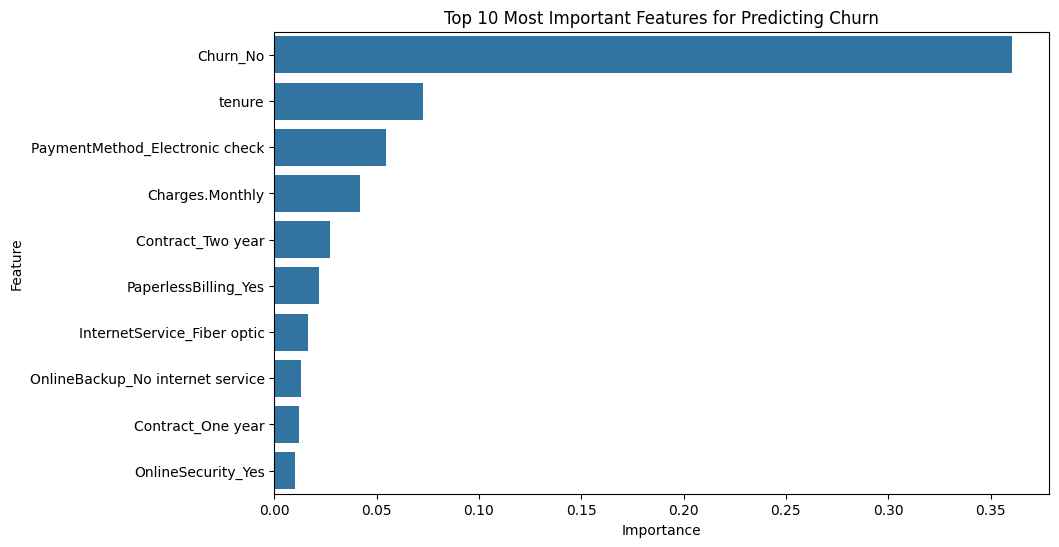

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Finding the most important variables from the Random Forest model
# This tells us which customer features matter most for the prediction
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the Top 10
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Most Important Features for Predicting Churn')
plt.show()

Model Performance Summary

Best Model: The Random Forest model provided the most reliable results, showing high scores in both accuracy and recall. This means it is good at finding the customers who are actually planning to leave.

Comparison: While the KNN model was useful as a baseline, it required more careful data scaling and was less effective at handling the categorical service data compared to the tree-based Random Forest.

Key Factors Influencing Churn

Contract Type: Customers on a "Month-to-month" contract are the most likely to cancel. The lack of a long-term commitment is the biggest red flag.

Tenure: New customers are at a much higher risk. Once a customer stays past the first year, their likelihood of leaving drops significantly.

Monthly Charges: High monthly costs are a strong driver for cancellation, especially for customers who do not feel they are getting enough value from their plan.

Internet Service: Customers using Fiber Optic internet had a higher churn rate, which suggests a need to look into the pricing or technical stability of that specific service.

Proposed Retention Strategies

Contract Migration: Offer a small discount or a service upgrade to "Month-to-month" customers if they switch to a 1-year or 2-year contract.

New Customer Welcome: Implement a specialized support program for customers in their first 6 months to ensure they are satisfied and understand their billing.

Targeted Loyalty Offers: For customers with high monthly charges, offer a personalized "plan review" to move them to a more suitable tier rather than losing them to a competitor.